In [177]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [283]:
df = pd.read_csv('./data/Top100_prediction_con.csv')
print(df.shape)
df.sample(5)

(1739323, 12)


,Unnamed: 0,id,store,date,sales,item,store_code,yearweek,sell_price,weekday,event,income
336440,13830240,SUPERMARKET_3_804_BOS_2,Roxbury,2012-04-26,12,SUPERMARKET_3_804,BOS_2,201217,2.2560,Thursday,0.0,27.072
532689,20692892,SUPERMARKET_3_154_BOS_3,Back_Bay,2012-12-07,9,SUPERMARKET_3_154,BOS_3,201249,3.5760,Friday,0.0,32.184
451610,17926777,SUPERMARKET_1_096_PHI_3,Queen_Village,2012-09-07,7,SUPERMARKET_1_096,PHI_3,201236,10.7280,Friday,0.0,75.096
982620,35135249,SUPERMARKET_1_012_NYC_4,Brooklyn,2014-03-26,10,SUPERMARKET_1_012,NYC_4,201412,6.3960,Wednesday,0.0,63.960
1240249,43086119,HOME_&_GARDEN_1_140_NYC_2,Harlem,2014-12-12,2,HOME_&_GARDEN_1_140,NYC_2,201449,18.7125,Friday,0.0,37.425


In [284]:
df_products = df[['id','date','sales','weekday','event']]

In [293]:
ts_predict = df_products[df_products['id']=='SUPERMARKET_3_586_NYC_3']
print(ts_predict.shape)
ts_predict.head()

(1913, 5)


,id,date,sales,weekday,event
167,SUPERMARKET_3_586_NYC_3,2011-01-29,56,Saturday,0.0
743,SUPERMARKET_3_586_NYC_3,2011-01-30,55,Sunday,0.0
1319,SUPERMARKET_3_586_NYC_3,2011-01-31,45,Monday,0.0
1895,SUPERMARKET_3_586_NYC_3,2011-02-01,57,Tuesday,0.0
2471,SUPERMARKET_3_586_NYC_3,2011-02-02,54,Wednesday,0.0


In [294]:
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)

In [295]:
ts_predict.head()

,id,date,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
167,SUPERMARKET_3_586_NYC_3,2011-01-29,56,0.0,0,0,1,0,0,0,0
743,SUPERMARKET_3_586_NYC_3,2011-01-30,55,0.0,0,0,0,1,0,0,0
1319,SUPERMARKET_3_586_NYC_3,2011-01-31,45,0.0,0,1,0,0,0,0,0
1895,SUPERMARKET_3_586_NYC_3,2011-02-01,57,0.0,0,0,0,0,0,1,0
2471,SUPERMARKET_3_586_NYC_3,2011-02-02,54,0.0,0,0,0,0,0,0,1


In [296]:
ts_predict['date'] = pd.to_datetime(ts_predict['date'])

In [297]:
ts_predict.sort_values('date', ascending=True, inplace=True)

In [298]:
ts_predict.set_index('date', inplace=True)

In [291]:
ts_predict.tail(1)

,id,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,,
2016-04-24,SUPERMARKET_3_586_NYC_3,78,0.0,0,0,0,1,0,0,0


In [292]:
ts_predict = ts_predict[['sales']]
ts_predict.head(1)

,sales
date,
2011-01-29,56


In [225]:
ts_predict = ts_predict.asfreq('D')

Train dates : 2011-01-29 00:00:00 --- 2016-03-25 00:00:00  (n=1883)
Test dates  : 2016-03-26 00:00:00 --- 2016-04-24 00:00:00  (n=30)


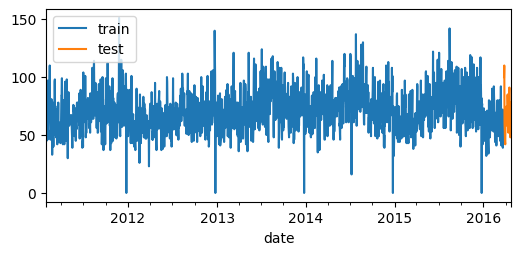

In [226]:
steps = 30
data_train = ts_predict[:-steps]
data_test  = ts_predict[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['sales'].plot(ax=ax, label='train')
data_test['sales'].plot(ax=ax, label='test')
ax.legend();

In [227]:
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

## Sin Hiperparámetros

In [228]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 3
             )
forecaster.fit(y=data_train['sales'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-29 00:00:00'), Timestamp('2016-03-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-09-11 17:22:27 
Last fit date: 2024-09-11 17:22:33 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecaste

In [229]:
predictions = forecaster.predict(steps=30)

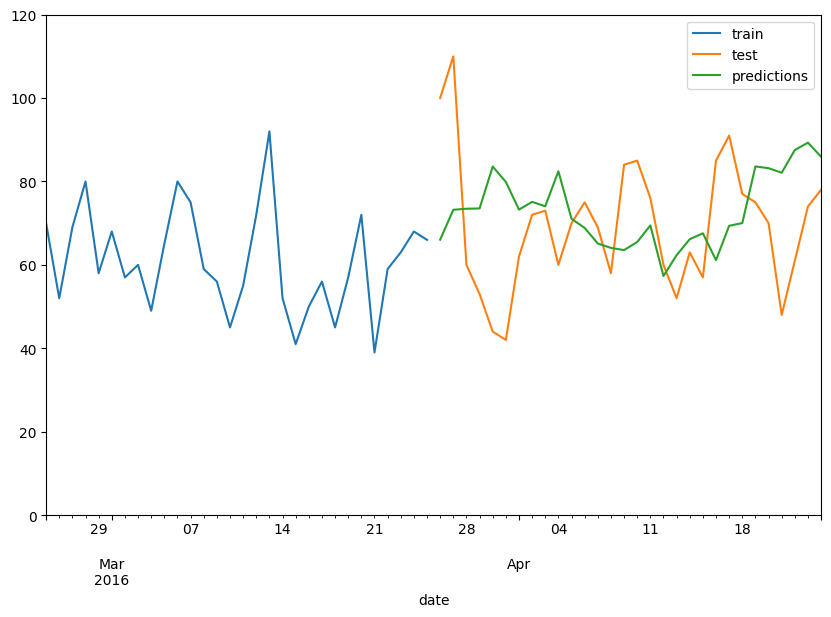

In [230]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [231]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 380.6064433481481


## CON HIPERPARÁMETROS

In [232]:
# Hyperparameters: grid search
# ==============================================================================
steps = 30
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data_train['sales'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(data_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 28.


lags grid:   0%|          | 0/7 [00:00<?, ?it/s]

lags grid: 100%|██████████| 7/7 [05:47<00:00, 49.68s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 291.00062188919816



In [279]:
regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['sales'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, n_estimators=250, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-01-29 00:00:00'), Timestamp('2016-03-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-09-11 18:22:22 
Last fit date: 

In [280]:
predictions = forecaster.predict(steps=30)

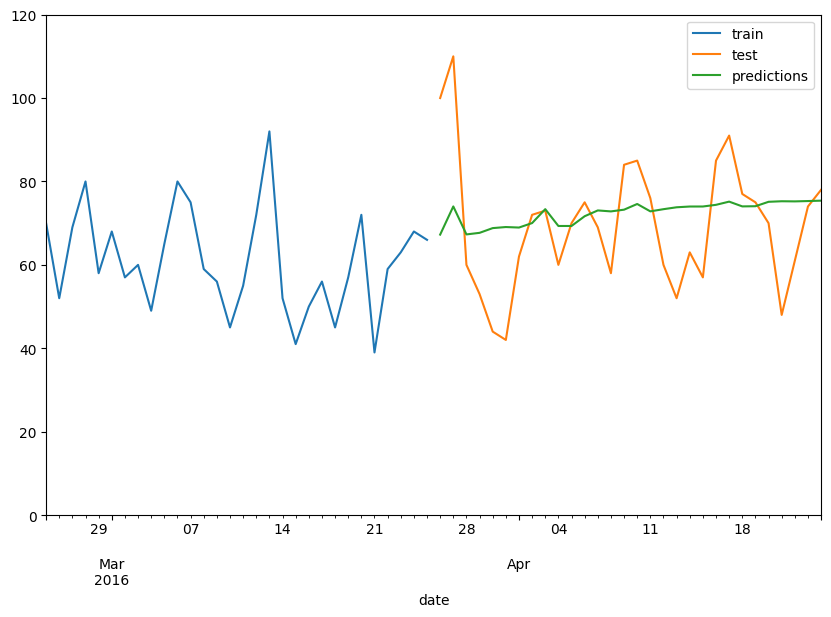

In [281]:
fig, ax = plt.subplots(figsize=(10, 6.5))
data_train['sales'][-30:].plot(ax=ax, label='train')
data_test['sales'][-30:].plot(ax=ax, label='test')
ax.set_ylim(0,120)
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [282]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

ValueError: Found input variables with inconsistent numbers of samples: [1913, 30]

## Con exógenas

In [256]:
data_test = ts_predict.copy()

In [257]:
ts_predict.head(1)

,id,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,,
2011-01-29,SUPERMARKET_3_586_NYC_3,56,0.0,0,0,1,0,0,0,0


In [258]:
ts_predict.sort_values('date', ascending=True)
ts_predict.head(1)

,id,sales,event,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,,
2011-01-29,SUPERMARKET_3_586_NYC_3,56,0.0,0,0,1,0,0,0,0


In [118]:
# # Definir el punto de división (80% de los datos para entrenamiento)
# train_size = -30

# # Dividir la serie objetivo en train y test
# y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # Dividir las variables exógenas en train y test
# exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

In [259]:
y = ts_predict['sales']
y = y.asfreq('D')

In [260]:
y.head(1)

date
2011-01-29    56
Freq: D, Name: sales, dtype: int64

In [261]:
exog = ts_predict[['event', 'weekday_Friday', 'weekday_Monday','weekday_Saturday', 'weekday_Sunday','weekday_Thursday','weekday_Tuesday','weekday_Wednesday']]
exog = exog.asfreq('D')

In [262]:
y_train, y_test= y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [263]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags=10  # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['event', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'] 
Training range: [Timestamp('2011-01-29 00:00:00'), Timestamp('2016-03-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
fi

In [264]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

# Evaluar el modelo comparando las predicciones con los valores reales
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 181.3410633333333


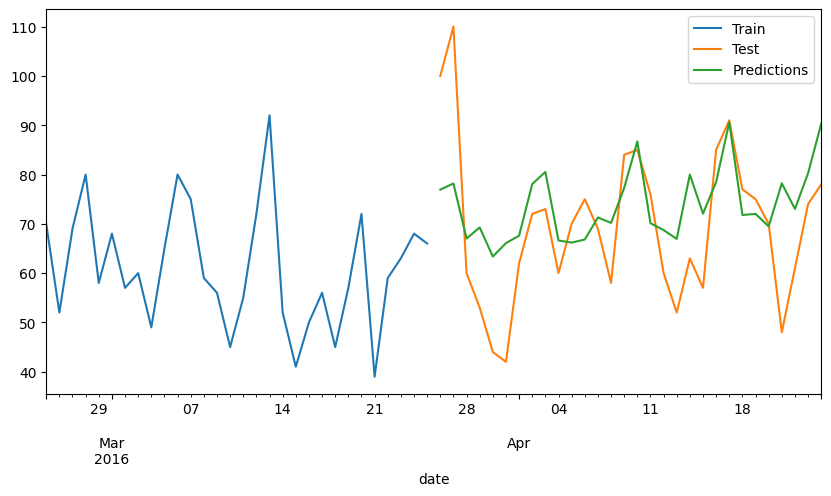

In [266]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()

### CON HIPERPARAMETROS - EXOGENA

In [324]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import numpy as np

# Definir el modelo con un regressor base
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=5  # Esta es solo una configuración inicial, la ajustaremos con GridSearch
)

# Parámetros del RandomForest y los lags a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Muestras mínimas en una hoja
}

lags_grid = [7, 14, 21, 30]

# Realizar el GridSearch
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  # Serie temporal de entrenamiento
    exog=exog_train,  # Variables exógenas si tienes alguna
    param_grid=param_grid,  # La cuadrícula de parámetros
    lags_grid=lags_grid,
    steps=7,  # Cuántos pasos (días) predecir hacia adelante
    metric='mean_squared_error',  # Métrica de evaluación (también puede ser MAE, etc.)
    initial_train_size=len(y_train) - 30,  # Tamaño inicial de la ventana de entrenamiento
    refit=True,  # Reentrenar el modelo en cada combinación de hiperparámetros
    return_best=True,  # Devolver el mejor modelo
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  25%|██▌       | 1/4 [05:00<15:02, 300.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  50%|█████     | 2/4 [09:50<09:48, 294.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  75%|███████▌  | 3/4 [16:43<05:48, 348.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid: 100%|██████████| 4/4 [26:45<00:00, 401.29s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  Backtesting metric: 1585.8853538881854

Mejores parámetros:                                                   lags  \
46     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
43     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
37     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
40     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
64     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
..                                                 ...   
111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
117  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
114  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
108  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
141  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  

In [268]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

# Crear el forecaster con el modelo que quieras (ej. RandomForest)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(max_depth=None, min_samples_leaf=2,min_samples_split=5, n_estimators=100),
    lags=14  # Usamos 7 días de rezago, ajusta según sea necesario
)

# Entrenar el forecaster usando los datos de entrenamiento y variables exógenas
forecaster.fit(y=y_train, exog=exog_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(min_samples_leaf=2, min_samples_split=5) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['event', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday'] 
Training range: [Timestamp('2011-01-29 00:00:00'), Timestamp('2016-03-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_s

In [270]:
# Hacer predicciones para el tamaño del conjunto de prueba
steps = len(y_test)  # Número de pasos igual al tamaño de y_test
predictions = forecaster.predict(steps=steps, exog=exog_test)

# Evaluar el modelo comparando las predicciones con los valores reales
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 160.19608625377103


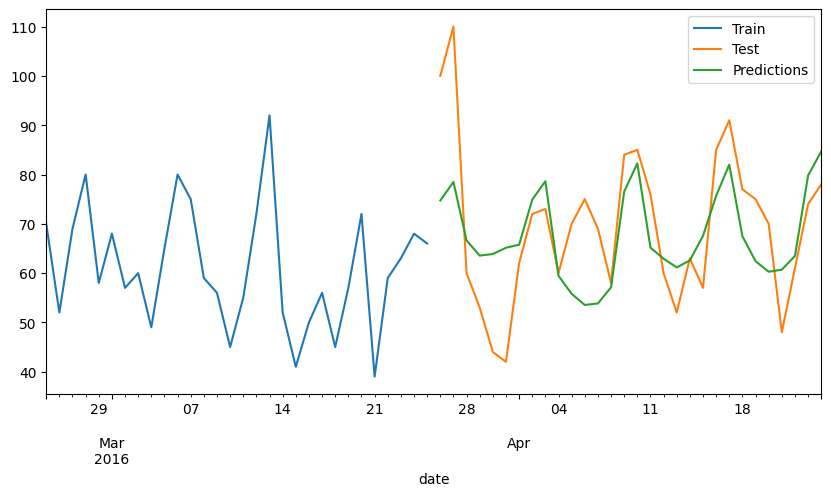

In [273]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()